In [1]:
import pandas as pd
import graph_ruggedness_de
import numpy as np
import random
import sequence_evolution
import solution_space_simulation
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler
import gaussian_markov_random_field
from timestep_opt import fit_t_bayesian_laplace
import graph_utils
import nk_landscape

## Figure 5

The purpose of Figure 5 is to demonstrate that the ruggedness of a fitness map with constant degree is dictated / bounded by the size of the solution space, that is, the number of edges that connect nodes with fitness above a selectable threshold. This is done using sequence space simulation from `sequence_evolution` and Fiedler-based spectral clustering from `solution_space_simulation`.

The below cell performs a sequence evolution simulation using `sequence_evolution.sequence_evolution` with realistic evolutionary parameters. This determines the fitness landscape topology to assess solution space over. 

In [2]:
rep_dict = {}
rep_de_dict = {}
rep_sample_info_dict = {}

#Iterate through landscape simulations.
for _ in range(1):
    #Sample evolutionary parameters.
    num_nodes = 200
    #num_nodes = np.random.randint(200, 1000)
    mean_branch_length = np.random.uniform(0.01, 0.5)
    std_dev_branch_length = np.random.uniform(0.001, 0.1)
    alpha = np.random.uniform(0.1, 0.5)
    model = random.choice(('WAG', 'LG'))
    rate_categoies = 4
    sequence_length = int(np.random.uniform(100, 600))

    sample_info = {
        'num_nodes' : num_nodes,
        'mean_branch_length' : mean_branch_length,
        'std_dev_branch_length' : std_dev_branch_length,
        'alpha' : alpha,
        'model' : model,
        'sequence_length' : sequence_length
    }

    #Perform sequence evolution.
    seq_dict = sequence_evolution.sequence_evolution(num_nodes=num_nodes,
                                                    mean_branch_length=mean_branch_length,
                                                    std_dev_branch_length=std_dev_branch_length,
                                                    alpha=alpha,
                                                    model=model,
                                                    rate_categories=rate_categoies,
                                                    sequence_length=sequence_length
                                                    )
    #Construct graph from simulated sequences.

    seq_ls = list(seq_dict.values())
    values = [0]*len(seq_ls)
    G = graph_ruggedness_de.build_ohe_graph(seq_ls=seq_ls,
                                        values=values)

Computing all vs. all OHE distance matrix.
Done.
Finding K-nearest neighbors.
Done.
Added 2800 KNN edges.


The below cell uses spectral clustering functions `solution_space_simulation.spectral_cluster` and `solution_space_simulation.assign_clustered_values` to cluster nodes in the fitness landscape `G` according to graph topology. By increasing the number of clusters, `k`, the size of the cluster decreases, therefore reducing the size of the solution space over `G`. `solution_space_simulation.count_deltaS` and `solution_space_simulation.count_epsilonS` are used to count the number of edges that are separated by the solution space boundary and are within the solution space set, respectively. 

In [5]:
energies_dict = {}
delta_s_dict = {}
epsilon_s_dict = {}
solution_size_dict = {}
t_vals_dict = {}

for replicate in range(50):

    dir_energies = []
    delta_s = []
    epsilon_s = []
    solution_size = []
    t_vals = []

    for clusters in range(2,20):

        G_clstr = solution_space_simulation.spectral_cluster(G=G,
                                                            k=clusters)

        G_clstr = solution_space_simulation.assign_clustered_values(G=G_clstr)

        values = [node[1]['value'] for node in G_clstr.nodes(data=True)]

        solution_size.append(values.count(1))

        viridis = plt.cm.get_cmap('viridis', 10)

        laplacian = nx.laplacian_matrix(G_clstr).toarray()
        dir_en = values @ laplacian @ values
        t_map, ci_lower, ci_upper, logpost_map, var_approx = fit_t_bayesian_laplace(G=G_clstr)

        t_vals.append(t_map)
        dir_energies.append(dir_en)

        inter_s = solution_space_simulation.count_deltaS(G=G_clstr)
        intra_s = solution_space_simulation.count_epsilonS(G=G_clstr)

        delta_s.append(inter_s)
        epsilon_s.append(intra_s)
    
    energies_dict[replicate] = dir_energies
    delta_s_dict[replicate] = delta_s
    epsilon_s_dict[replicate] = epsilon_s
    solution_size_dict[replicate] = solution_size
    t_vals_dict[replicate] = t_vals

/Users/matthewspence/venvs/torch/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/dm/sqfv0msd3g50txf84szl1c4m0000gn/T/ipykernel_80294/1417689233.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 10)
/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/gaussian_markov_random_field.py:130: RuntimeWarning: divide by zero encountered in divide
  inv_h_i_scaled = 1 / h_i_scaled
/Users/matthewspence/Documents/Documents/graph-ruggedness-de/src/gaussian_markov_random_field.py:130: RuntimeWarning: overflow encountered in divide
  inv_h_i_scaled = 1 / h_

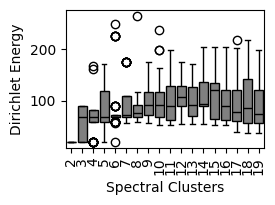

In [25]:
data_list = []
for replicate in energies_dict:
    observations = energies_dict[replicate]
    for index, obs in enumerate(observations):
        data_list.append({'Spectral Clusters': index+2, 'Dirichlet Energy': obs})

df = pd.DataFrame(data_list)

fig = plt.figure(figsize=(2.85,2.15))
sns.boxplot(x='Spectral Clusters', y='Dirichlet Energy', data=df, color='grey', linecolor='black')
# Display the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../figures/figure_5/panel_a.pdf')

plt.show()

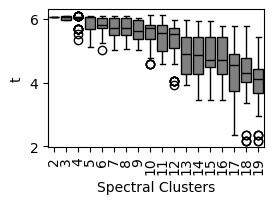

In [24]:
data_list = []
for replicate in t_vals_dict:
    observations = t_vals_dict[replicate]
    for index, obs in enumerate(observations):
        data_list.append({'Spectral Clusters': index+2, 't': obs})

df = pd.DataFrame(data_list)

fig = plt.figure(figsize=(2.85,2.15))
sns.boxplot(x='Spectral Clusters', y='t', data=df, color='grey', linecolor='black')
# Display the plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../figures/figure_5/panel_c.pdf')

plt.show()

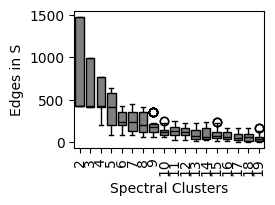

In [23]:
data_list = []
for replicate in epsilon_s_dict:
    observations = epsilon_s_dict[replicate]
    for index, obs in enumerate(observations):
        data_list.append({'Spectral Clusters': index+2, 'Edges in S': obs})

df = pd.DataFrame(data_list)

fig = plt.figure(figsize=(2.85,2.15))
sns.boxplot(x='Spectral Clusters', y='Edges in S', data=df, color='grey', linecolor='black')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../figures/figure_5/panel_b.pdf')
plt.show()

## Plotting the fitness landscape


/Users/matthewspence/venvs/torch/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


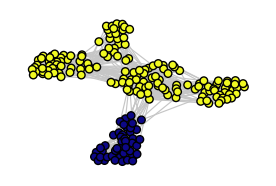

/Users/matthewspence/venvs/torch/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


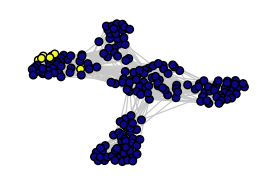

In [ ]:
G_clstr = solution_space_simulation.spectral_cluster(G=G,
                                                    k=2)

G_clstr = solution_space_simulation.assign_clustered_values(G=G_clstr)

G = G_clstr
pos = nx.spring_layout(G) 
signal = np.array([G.nodes[n]['value'] for n in G.nodes()])

fig, ax = plt.subplots(figsize=(2.65, 1.75), constrained_layout=True)

norm0, cmap0 = graph_utils.visualize_signal_over_graph(G=G, pos=pos, signal=signal, ax=ax, nodesize=30, cmap='plasma')

#plt.savefig('../figures/figure_2/panel_d.pdf', bbox_inches='tight')
plt.show()


G_clstr = solution_space_simulation.spectral_cluster(G=G,
                                                    k=50)
G_clstr = solution_space_simulation.assign_clustered_values(G=G_clstr)
G = G_clstr

signal = np.array([G.nodes[n]['value'] for n in G.nodes()])

fig, ax = plt.subplots(figsize=(2.65, 1.75), constrained_layout=True)

norm0, cmap0 = graph_utils.visualize_signal_over_graph(G=G, pos=pos, signal=signal, ax=ax, nodesize=30, cmap='plasma')

#plt.savefig('../figures/figure_2/panel_d.pdf', bbox_inches='tight')
plt.show()



/Users/matthewspence/venvs/torch/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


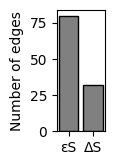

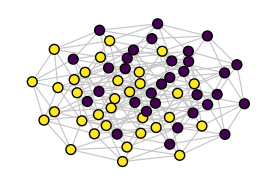

/Users/matthewspence/venvs/torch/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


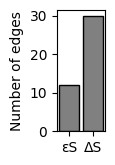

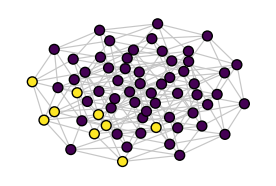

In [106]:
G_k=nk_landscape.generate_nk_landscape_amino_acids(N=6, amino_acids=["A", "B"], K=0)
G_clstr = solution_space_simulation.spectral_cluster(G=G_k,
                                                    k=2)
G_clstr = solution_space_simulation.assign_clustered_values(G=G_clstr)
G = G_clstr

inter_s = solution_space_simulation.count_deltaS(G=G)
intra_s = solution_space_simulation.count_epsilonS(G=G)

fig = plt.figure(figsize=(1.25, 1.75))
plt.bar(x=['εS', 'ΔS'], height=[intra_s, inter_s], color='grey', edgecolor='black')
plt.ylabel('Number of edges')
plt.tight_layout()
plt.savefig('../figures/figure_5/panel_g.pdf', bbox_inches='tight')
plt.show()

pos = nx.spring_layout(G) 
signal = np.array([G.nodes[n]['value'] for n in G.nodes()])
fig, ax = plt.subplots(figsize=(2.65, 1.75), constrained_layout=True)
norm0, cmap0 = graph_utils.visualize_signal_over_graph(G=G, pos=pos, signal=signal, ax=ax, nodesize=50, cmap='viridis')

plt.savefig('../figures/figure_5/panel_d.pdf', bbox_inches='tight')
plt.show()


G_clstr = solution_space_simulation.spectral_cluster(G=G_k,
                                                    k=8)
G_clstr = solution_space_simulation.assign_clustered_values(G=G_clstr)
G = G_clstr

inter_s = solution_space_simulation.count_deltaS(G=G)
intra_s = solution_space_simulation.count_epsilonS(G=G)

fig = plt.figure(figsize=(1.25, 1.75))
plt.bar(x=['εS', 'ΔS'], height=[intra_s, inter_s], color='grey', edgecolor='black')
plt.ylabel('Number of edges')
plt.tight_layout()
plt.savefig('../figures/figure_5/panel_f.pdf', bbox_inches='tight')
plt.show()

signal = np.array([G.nodes[n]['value'] for n in G.nodes()])
fig, ax = plt.subplots(figsize=(2.65, 1.75), constrained_layout=True)
norm0, cmap0 = graph_utils.visualize_signal_over_graph(G=G, pos=pos, signal=signal, ax=ax, nodesize=50, cmap='viridis')

plt.savefig('../figures/figure_5/panel_e.pdf', bbox_inches='tight')
plt.show()